In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
Base = automap_base()

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
year = timedelta(days=365)
latest_date = session.query(func.max(measurements.date)).filter().all()

latest_date = dt.datetime.strptime(latest_date[0][0], '%Y-%m-%d')
one_year = latest_date - year
one_year

datetime.datetime(2016, 8, 23, 0, 0)

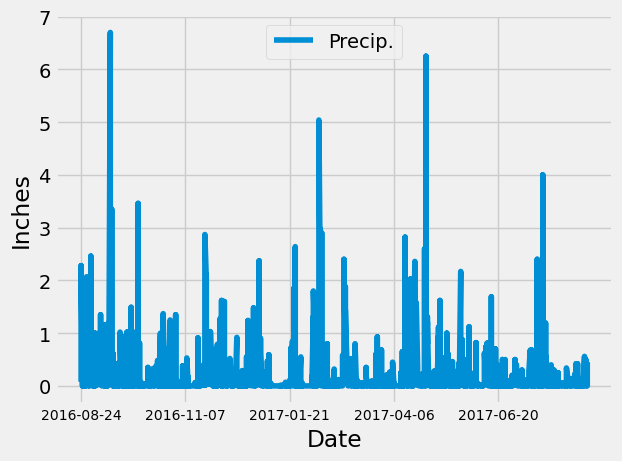

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
last_year = session.query(measurements.date).filter(measurements.date >= one_year)\
    .order_by(measurements.date).all()

# Perform a query to retrieve the data and precipitation scores
data = session.query(measurements).with_entities(measurements.date, measurements.prcp)\
    .filter(measurements.date >= one_year).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(data)
rain_df = rain_df.rename(columns={'date': 'Date', 'prcp': 'Inches'})
# Sort the dataframe by date
rain_df= rain_df.dropna()
rain_df = rain_df.sort_values(by='Date',ascending=True)
rain_df

# Use Pandas Plotting with Matplotlib to plot the data
rainx = rain_df['Date']
rainy = rain_df['Inches']
x_ticks = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.plot(rainx, rainy)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(ticks=[0, 75, 150, 225, 300], size=10)
plt.legend(labels=['Precip.'], loc='upper center')
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain = rain_df['Inches']
rain_count = len(rain)
rain_mean = rain.mean().round(6)
rain_std = rain.std()
rain_min = rain.min()
rain_25 = rain.quantile(q=0.25)
rain_50 = rain.quantile(q=0.5)
rain_75 = rain.quantile(q=0.75)
rain_max = rain.max()

rain_summary_df = pd.DataFrame([{'count': rain_count, 'mean':rain_mean, 'std':rain_std, 'min': rain_min, \
    '25%':rain_25, '50%':rain_50, '75%':rain_75, 'max':rain_max}])

# formatting
rain_summary_df = rain_summary_df.swapaxes('index', 'columns').rename(columns= {0:'precipitation'})
rain_summary_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(stations).count()
total_stations

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_values = session.query(measurements.station, func.count(measurements.station))\
    .order_by(func.count(measurements.station).desc()).group_by(measurements.station).all()
most_active = station_values[0][0]
# 
station_values
print(station_values)
print(f"The most active station is {most_active}.")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
The most active station is USC00519281.


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_low = session.query(measurements.tobs).filter(measurements.station == most_active)\
    .order_by(measurements.tobs.asc()).first()
active_high = session.query(measurements.tobs).filter(measurements.station == most_active)\
    .order_by(measurements.tobs.desc()).first()
active_avg = session.query(func.avg(measurements.tobs)).filter(measurements.station == most_active).all()
fixed_active_low = float(active_low[0])
fixed_active_high = float(active_high[0])
fixed_active_avg = float(active_avg[0][0])

print(f"The station with the most data points is {most_active}.")
print(f"The lowest temperature recorded in the dataset at station {most_active} is {fixed_active_low}F.")
print(f"The highest temperature recorded in the dataset at station {most_active} is {fixed_active_high}F.")
print(f"The average temperature recorded at station {most_active} is {fixed_active_avg}F.")

The station with the most data points is USC00519281.
The lowest temperature recorded in the dataset at station USC00519281 is 54.0F.
The highest temperature recorded in the dataset at station USC00519281 is 85.0F.
The average temperature recorded at station USC00519281 is 71.66378066378067F.


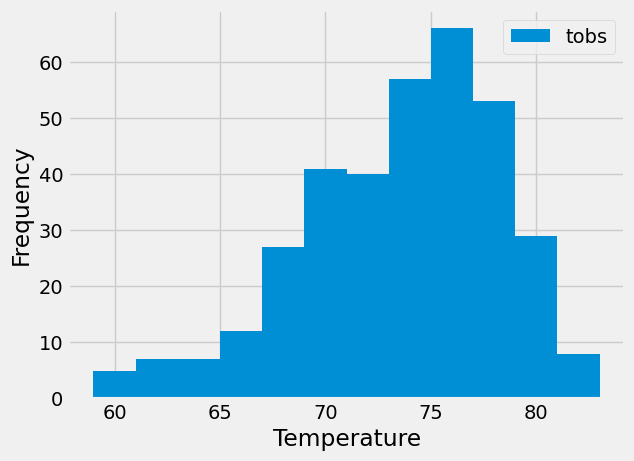

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temps = session.query(measurements.tobs, func.count(measurements.tobs))\
    .filter(measurements.station == 'USC00519281',measurements.date >= '2016-08-23')\
    .group_by(measurements.tobs).all()
active_temps

active_db = pd.DataFrame(active_temps, columns= ['Temperature', 'Frequency'])
counts = active_db['Frequency']
temps = active_db['Temperature']
plt.hist(temps, bins=12, weights=counts)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(labels=['tobs'], loc='best')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()